# Mask R-CNN - Test on Old Shapes Dataset

Run the Mask R-CNN net in inference mode, with the additional PCILayer that generates the context-based tensor 

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_newshapes_test
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)


model_file  = 'E:\\Models\\newshape_fcn\\\mask_rcnn_shapes_0589.h5'
folder_name = 'newshape_fcn'
model, dataset_test, test_generator, inference_config = prep_newshapes_test(init_with = model_file, FCN_layers = True, batch_sz = 1, folder_name = folder_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 Initialize config object - super
(56, 56)
 Shapes Per Image:  7
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\models\newshape_fcn\shapes20180618T1702\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> RPN Layer 
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     depth

In [16]:
from matplotlib import pyplot as plt
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Detection

### Test on a random image

Image Id : 2179
{ 'bg_color': array([ 51, 228,  89]),
  'height': 128,
  'id': 2179,
  'path': None,
  'shapes': [ ('sun', (89, 75, 191), (62, 20, 8, 8)),
              ('cloud', (234, 189, 178), (71, 28, 31, 10)),
              ('building', (39, 197, 213), (24, 42, 10, 10)),
              ('building', (215, 254, 250), (88, 43, 10, 10)),
              ('building', (66, 68, 151), (46, 76, 17, 25))],
  'source': 'shapes',
  'width': 128}

 shape list --------------------------
[ ('sun', (89, 75, 191), (62, 20, 8, 8)),
  ('cloud', (234, 189, 178), (71, 28, 31, 10)),
  ('building', (39, 197, 213), (24, 42, 10, 10)),
  ('building', (215, 254, 250), (88, 43, 10, 10)),
  ('building', (66, 68, 151), (46, 76, 17, 25))]
original_image           shape: (128, 128, 3)         min:   39.00000  max:  254.00000
image_meta               shape: (15,)                 min:    0.00000  max: 2179.00000
[2179  128  128    3    0    0  128  128    1    1    1    1    1    1    1]
gt_class_id              shap

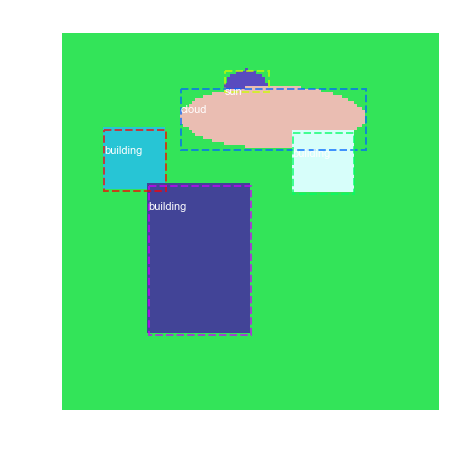

In [47]:
# Test on a random image
# Validation dataset
# dataset_val = shapes.ShapesDataset()
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()
import random
from mrcnn.utils import log

# image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False)
    

print('Image Id :', image_id)    
pp.pprint(dataset_test.image_info[image_id])

shape_list = dataset_test.image_info[image_id]['shapes']
print('\n shape list --------------------------')
pp.pprint(shape_list)
log("original_image", original_image)
log("image_meta", image_meta)
print(image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(gt_bbox.shape, gt_class_id.shape)
print(" 1: person   2: car  3: sun  4: building  5: tree  6: cloud ")
visualize.display_instances(original_image, gt_bbox,   gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

In [40]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (128, 128, 3)         min:   13.00000  max:  254.00000
molded_images            shape: (1, 128, 128, 3)      min:  -96.70000  max:  146.10000
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000
    Wrapper for Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, ?, ?) (1, 1000, 4) <class 'numpy.ndarray'>
     mrcnn_class.shape  : (?, 1000, 7) (1, 1000, 7) <class 'numpy.ndarray'>
     mrcnn_bboxes.shape : (?, 1000, 7, 4) (1, 1000, 7, 4) <class 'numpy.ndarray'>
     image_meta         : (?, ?) (1, 15) <class 'numpy.ndarray'>


In [41]:
print(results)

[{'class_ids': array([4, 6, 4, 4, 3, 3, 5]), 'scores': array([1.    , 1.    , 1.    , 1.    , 0.9999, 0.9994, 0.9947], dtype=float32), 'rois': array([[ 33,  78,  54,  99],
       [ 18,  39,  38, 104],
       [ 51,  29, 102,  64],
       [ 32,  15,  53,  35],
       [  5,  80,  16,  91],
       [ 12,  55,  19,  70],
       [ 95,  55, 128, 100]])}]


  class ids  :  [4 6 4 4 3 3 5] <class 'numpy.ndarray'>
  class names:  ['BG', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
  scores     :  [1.     1.     1.     1.     0.9999 0.9994 0.9947] <class 'numpy.ndarray'>
(128, 128, 3)


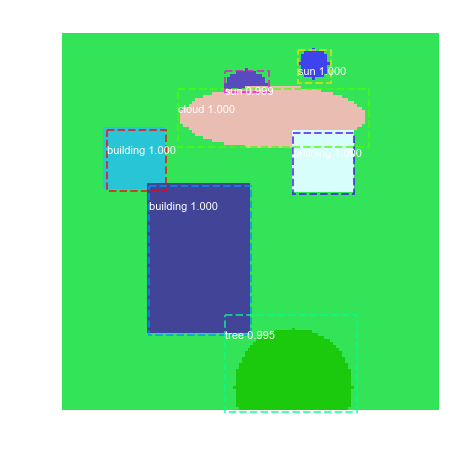

In [42]:
r = results[0]

print('  class ids  : ', r['class_ids'], type(r['class_ids']))
print('  class names: ', dataset_test.class_names)
print('  scores     : ', r['scores'], type(r['scores']))
visualize.display_instances(original_image, r['rois'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

In [38]:
color = tuple([random.randint(0, 255) for _ in range(3)])
dims  = (78,120,20,20)
shape = "sun"
# color, dims =dataset_test.random_shape("sun", 128,128)
# print(color, dims)
dataset_test.image_info[image_id]['shapes'].append((shape, color, dims))

In [46]:
dataset_test.image_info[image_id]['shapes'].pop()
pp.pprint(dataset_test.image_info[image_id])

{ 'bg_color': array([ 51, 228,  89]),
  'height': 128,
  'id': 2179,
  'path': None,
  'shapes': [ ('sun', (89, 75, 191), (62, 20, 8, 8)),
              ('cloud', (234, 189, 178), (71, 28, 31, 10)),
              ('building', (39, 197, 213), (24, 42, 10, 10)),
              ('building', (215, 254, 250), (88, 43, 10, 10)),
              ('building', (66, 68, 151), (46, 76, 17, 25))],
  'source': 'shapes',
  'width': 128}


## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
from mrcnn.datagen     import data_generator, load_image_gt
import  mrcnn.utils as utils 

image_ids = np.random.choice(dataset_test.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(utils.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

### Get next shapes from generator and display loaded shapes

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)

###  Simulation of `detect()` routine

In [ ]:
# print('>>> model detect()')
verbose = 1
images  = [original_image]
assert model.mode   == "inference", "Create model in inference mode."
assert len(images) == model.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

if verbose:
    log("Processing {} images".format(len(images)))
    for image in images:
        log("image", image)

# Mold inputs to format expected by the neural network
molded_images, image_metas, windows = model.mold_inputs(images)
if verbose:
    log("molded_images", molded_images)
    log("image_metas"  , image_metas)

## Run object detection pipeline
# print('    call predict()')
detections, rpn_rois, rpn_class, rpn_bbox,\
            mrcnn_class, mrcnn_bbox, mrcnn_mask \
                      =  model.keras_model.predict([molded_images, image_metas], verbose=0)

print('    return from  predict()')
print('    Length of detections : ', len(detections))
print('    Length of rpn_rois   : ', len(rpn_rois   ))
print('    Length of rpn_class  : ', len(rpn_class  ))
print('    Length of rpn_bbox   : ', len(rpn_bbox   ))
print('    Length of mrcnn_class: ', len(mrcnn_class))
print('    Length of mrcnn_bbox : ', len(mrcnn_bbox ))
print('    Length of mrcnn_mask : ', len(mrcnn_mask ))

####  detection array layout is `[ y1, x1, y2, x2, class, score]`

detections[0].shape
print(detections[0])

## Process detections
results = []
for i, image in enumerate(images):
    final_rois, final_class_ids, final_scores, final_masks =\
        model.unmold_detections(detections[i], 
                               mrcnn_mask[i],
                               image.shape  ,
                               windows[i])
    results.append({
        "rois"     : final_rois,
        "class_ids": final_class_ids,
        "scores"   : final_scores,
        "masks"    : final_masks,
    })